In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [5]:
# Load the synthetic data
df = pd.read_csv("../Data/synthetic_churn_data.csv")

In [6]:
# Separate features and target
X = df.drop(columns=['churn'])
y = df['churn']

In [7]:
# Identify categorical and numeric columns
categorical_cols = ['plan_type', 'contract_type']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [8]:
# Set up preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

In [9]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4000, 12)
Test set shape: (1000, 12)


In [12]:
# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [14]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

In [15]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

In [21]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9100
F1 Score: 0.0000
ROC-AUC: 0.5523

Confusion Matrix:
 [[910   3]
 [ 87   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       913
           1       0.00      0.00      0.00        87

    accuracy                           0.91      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg       0.83      0.91      0.87      1000



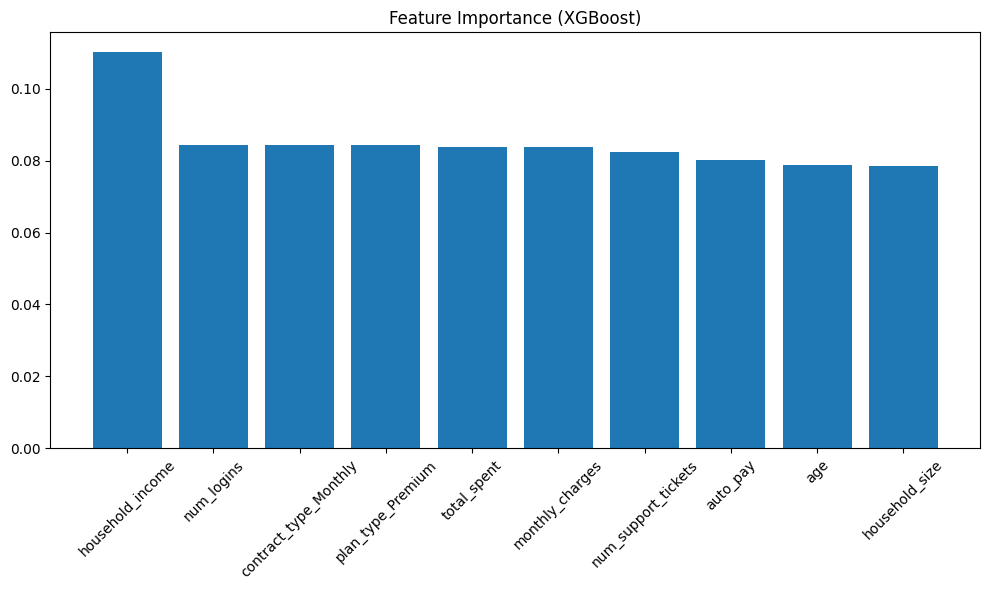

In [20]:
feature_names = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(categorical_cols)
    .tolist()
    + numeric_cols
)

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss'
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_dist,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)


Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Best ROC-AUC Score: 0.6322125677719432


In [28]:
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.6,
    'random_state': 42,
    'eval_metric': 'logloss'
}

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [29]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC-AUC: 0.63186916946784
Accuracy: 0.913
Confusion Matrix:
 [[913   0]
 [ 87   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       913
           1       0.00      0.00      0.00        87

    accuracy                           0.91      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg       0.83      0.91      0.87      1000



c:\Users\trist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\trist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\trist\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

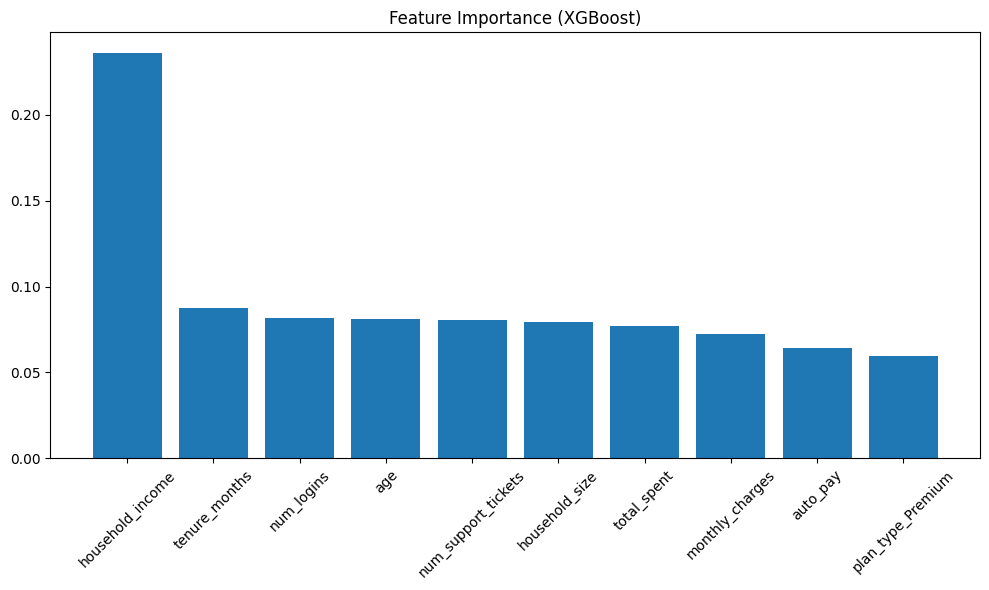

In [33]:
final_importances = final_model.feature_importances_
indices = np.argsort(final_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (XGBoost)")
plt.bar(range(10), final_importances[indices][:10], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

In [35]:
# Save the model
final_model.save_model('../Model/xgb_final_model.json')

# Load it later
from xgboost import XGBClassifier
loaded_model = XGBClassifier()
loaded_model.load_model('../Model/xgb_final_model.json')
